In [2]:
import nasdaqdatalink  # conda install nasdaq-data-link
import yahoo_fin.stock_info as yf  # conda install yahoo_fin

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

'''
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm  # pip install statsmodels
'''

import warnings
warnings.simplefilter("ignore")

plt.rcParams.update({'figure.figsize': (10, 6), 'figure.dpi': 80}) # set fig size

## Data gathering and processing 

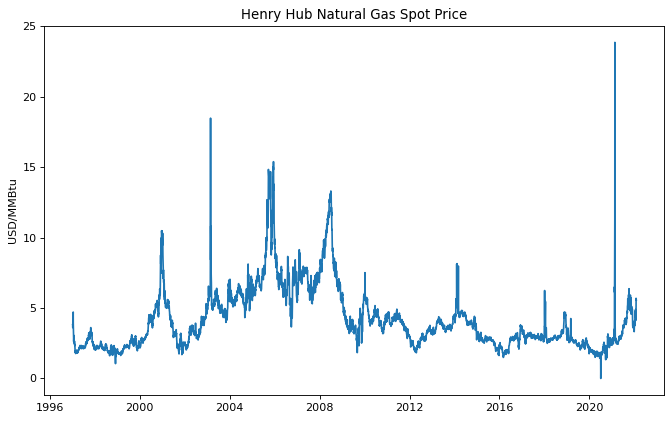

In [4]:
HH_spot_price = nasdaqdatalink.get('EIA/NG_RNGWHHD_D', 
                                   start_date='1997-01-07', 
                                   end_date='2022-01-31', 
                                   authtoken='Gymx-B5owcdhypB7ydu8')
plt.plot(HH_spot_price)
plt.title('Henry Hub Natural Gas Spot Price')
plt.ylabel('USD/MMBtu')
plt.show()

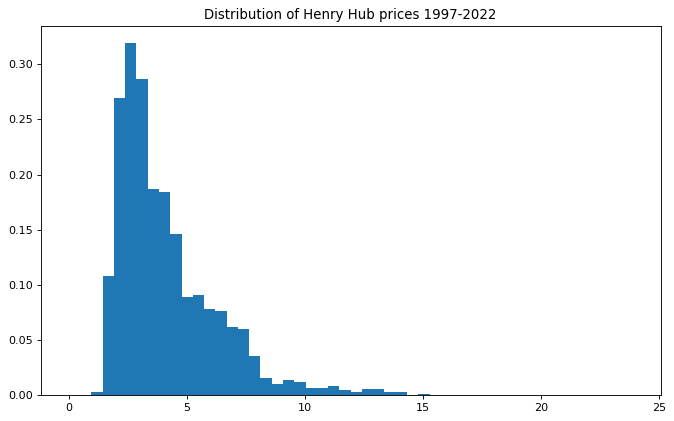

In [17]:
plt.hist(HH_spot_price, bins=50, density=True)
plt.title('Distribution of Henry Hub prices 1997-2022')
plt.show()

In [4]:
def get_datasets(source, startdate='1997-01-01', enddate='2021-12-31', auth="Gymx-B5owcdhypB7ydu8"):
    try:
        return nasdaqdatalink.get(source, start_date=startdate, end_date=enddate, authtoken=auth)
    except:
        return yf.get_data(source, start_date=startdate, end_date=enddate, interval='1mo')['adjclose'].to_frame()

features = [
  'US_gas_consumption',
  'US_gas_supply',
  'US_storage_volume',
  'US_gas_exports',
  'US_gas_imports',
  'WTI_spot_price',
  'gas_futures_1',
  #'US_PMI',  missing values
  'US_CPI',
  'dow_jones',
  '3m_treasury',
  '5y_treasury',
  #'USD/EUR'  missing values
]

API_mapping = {
    'HH_spot_price':'EIA/NG_RNGWHHD_M',
    'US_gas_consumption':'EIA/STEO_NGTCPUS_M',
    'US_gas_supply':'EIA/STEO_NGPSUPP_M',
    'US_storage_volume':'EIA/NG_N5020US2_M',
    'US_gas_exports':'EIA/NG_N9130US2_M',
    'US_gas_imports':'EIA/NG_N9100US2_M',
    'gas_futures_1':'EIA/NG_RNGC1_M',
    'WTI_spot_price':'EIA/PET_RWTC_M',
    'US_PMI':'FRED/NAPM',
    'US_CPI':'RATEINF/CPI_USA',
    'dow_jones':'^DJI',
    '3m_treasury':'^IRX',
    '5y_treasury':'^FVX',
    'USD/EUR':'EUR=X'
}

In [5]:
df = pd.DataFrame()  # contains all features indexed by date
for feature in features:
    data = get_datasets(API_mapping[feature])
    df = pd.concat([df, data], axis=1, join='outer')
df = df.set_axis(features, axis=1, copy=False)  # rename the columns to match the features
df = df.resample('M').mean()  # align monthly indices
df

,US_gas_consumption,US_gas_supply,US_storage_volume,US_gas_exports,US_gas_imports,WTI_spot_price,gas_futures_1,US_CPI,dow_jones,3m_treasury,5y_treasury
1997-01-31,81.946492,84.198499,1495563.0,12028.0,278288.0,25.13,3.067,159.100,6813.089844,5.010,6.250
1997-02-28,81.200033,74.303301,1139422.0,12443.0,240545.0,22.18,2.065,159.600,6877.740234,5.070,6.368
1997-03-31,69.557141,65.940162,990433.0,16276.0,256985.0,20.97,1.899,160.000,6583.479980,5.170,6.759
1997-04-30,61.401220,57.639494,1051235.0,13872.0,238178.0,19.70,2.005,160.200,7009.000000,5.100,6.565
1997-05-31,53.216020,49.180900,1364797.0,10097.0,241732.0,20.82,2.253,160.100,7331.000000,4.820,6.508
...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31,77.733115,78.083497,2915598.0,563650.0,220959.0,67.70,4.030,273.567,35360.730469,0.040,0.772
2021-09-30,70.336595,70.231507,3304886.0,535660.0,220206.0,71.65,5.120,274.310,33843.921875,0.028,0.997
2021-10-31,72.180108,73.880276,3664591.0,545121.0,228203.0,81.48,5.580,276.589,35819.558594,0.048,1.188
2021-11-30,88.210309,91.001054,3531966.0,557080.0,242405.0,79.15,5.100,277.948,34483.718750,0.048,1.150


### Missing data?

In [6]:
for feature in features:
    print('Missing', feature, 'data:', np.round(df[feature].isna().sum()/df.shape[0]*100, 4), '%')

Missing US_gas_consumption data: 0.0 %
Missing US_gas_supply data: 0.0 %
Missing US_storage_volume data: 0.3333 %
Missing US_gas_exports data: 0.3333 %
Missing US_gas_imports data: 0.3333 %
Missing WTI_spot_price data: 0.0 %
Missing gas_futures_1 data: 0.0 %
Missing US_CPI data: 0.0 %
Missing dow_jones data: 0.0 %
Missing 3m_treasury data: 0.0 %
Missing 5y_treasury data: 0.0 %


In [7]:
df = df.fillna(method="ffill")

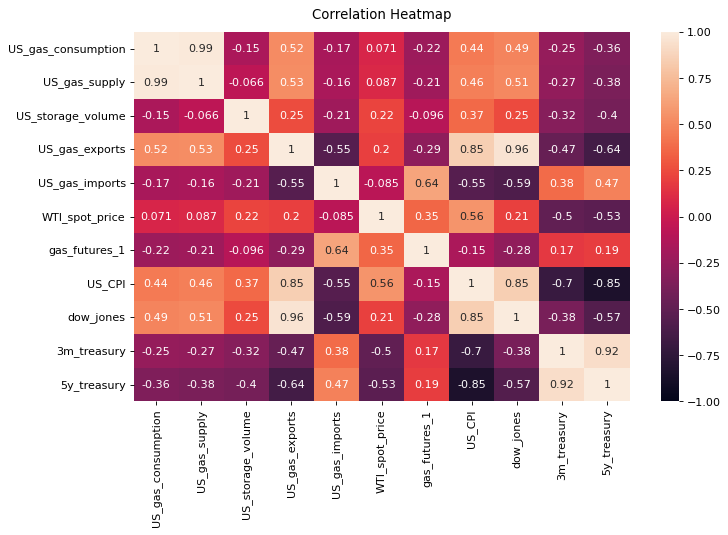

In [8]:
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

### Add the lagged value of the spot price

In [9]:
df['next_month_HH_spot_price'] = nasdaqdatalink.get('EIA/NG_RNGWHHD_M', start_date='1997-01-07', end_date='2022-01-31').shift(-1)
df['HH_spot_price'] = nasdaqdatalink.get('EIA/NG_RNGWHHD_M', start_date='1997-01-07', end_date='2022-01-31')  # current month spot
df['last_month_HH_spot_price'] = df['HH_spot_price'].shift(1)  # one month lagged spot

features += ['HH_spot_price', 'last_month_HH_spot_price']  # new features
df = df.dropna()
df

,US_gas_consumption,US_gas_supply,US_storage_volume,US_gas_exports,US_gas_imports,WTI_spot_price,gas_futures_1,US_CPI,dow_jones,3m_treasury,5y_treasury,next_month_HH_spot_price,HH_spot_price,last_month_HH_spot_price
1997-02-28,81.200033,74.303301,1139422.0,12443.0,240545.0,22.18,2.065,159.600,6877.740234,5.070,6.368,1.89,2.15,3.45
1997-03-31,69.557141,65.940162,990433.0,16276.0,256985.0,20.97,1.899,160.000,6583.479980,5.170,6.759,2.03,1.89,2.15
1997-04-30,61.401220,57.639494,1051235.0,13872.0,238178.0,19.70,2.005,160.200,7009.000000,5.100,6.565,2.25,2.03,1.89
1997-05-31,53.216020,49.180900,1364797.0,10097.0,241732.0,20.82,2.253,160.100,7331.000000,4.820,6.508,2.20,2.25,2.03
1997-06-30,51.212553,46.050134,1731133.0,9527.0,232118.0,19.26,2.161,160.300,7672.799805,5.050,6.383,2.19,2.20,2.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-31,77.733115,78.083497,2915598.0,563650.0,220959.0,67.70,4.030,273.567,35360.730469,0.040,0.772,5.16,4.07,3.84
2021-09-30,70.336595,70.231507,3304886.0,535660.0,220206.0,71.65,5.120,274.310,33843.921875,0.028,0.997,5.51,5.16,4.07
2021-10-31,72.180108,73.880276,3664591.0,545121.0,228203.0,81.48,5.580,276.589,35819.558594,0.048,1.188,5.05,5.51,5.16
2021-11-30,88.210309,91.001054,3531966.0,557080.0,242405.0,79.15,5.100,277.948,34483.718750,0.048,1.150,3.76,5.05,5.51


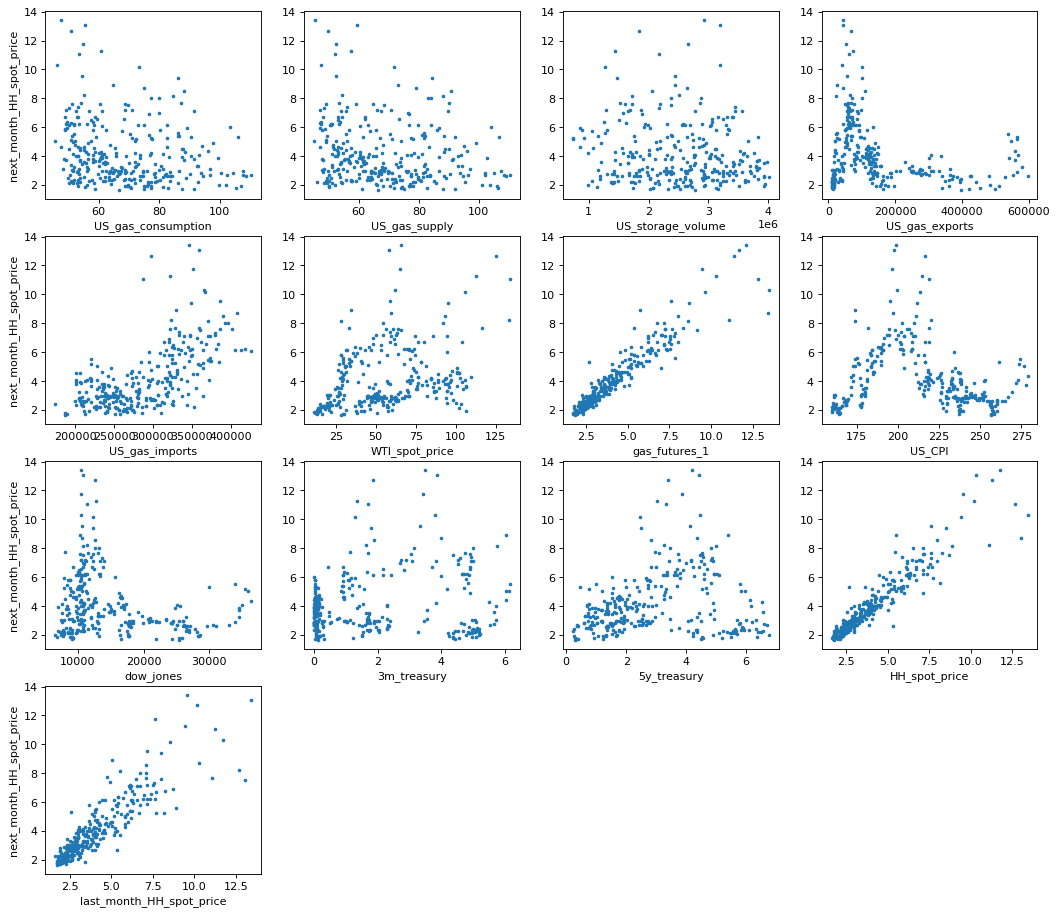

In [36]:
i=1
plt.figure(figsize = (16,14))
for feature in features:
    plt.subplot(4,4,i)
    plt.scatter(df[feature], df['next_month_HH_spot_price'], s=5)
    plt.xlabel(feature)
    if i%4==1: plt.ylabel('next_month_HH_spot_price')
    i += 1
plt.show()

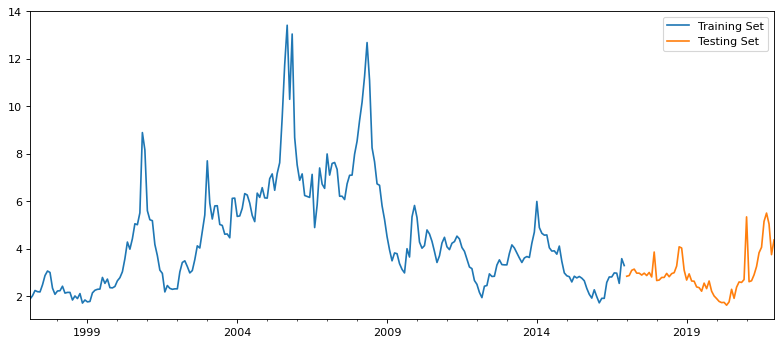

In [37]:
train = df.loc[df.index <= '2016-12-31']
test = df.loc[df.index >= '2017-01-01']

fig, ax = plt.subplots(figsize=(12,5))
train['next_month_HH_spot_price'].plot(ax=ax, label='Training Set')
test['next_month_HH_spot_price'].plot(ax=ax, label='Testing Set')
plt.legend()
plt.show()

## Model #1: Linear Model

#### Least Square Model

In [699]:
from sklearn.linear_model import LinearRegression

model_ols = LinearRegression()
X_train, y_train = train.drop('next_month_HH_spot_price', axis=1), train['next_month_HH_spot_price']
X_test, y_test = test.drop('next_month_HH_spot_price', axis=1), test['next_month_HH_spot_price']
model_ols.fit(X_train, y_train)
dict(zip(features, model_ols.coef_))

{'US_gas_consumption': -0.03186287820274712,
 'US_gas_supply': 0.023695498456901023,
 'US_storage_volume': -2.2702647582001356e-07,
 'US_gas_exports': 5.3366154433099125e-06,
 'US_gas_imports': 2.802640776715303e-06,
 'WTI_spot_price': 0.007028844300919497,
 'gas_futures_1': 1.1370493883646342,
 'US_CPI': -0.013349817354821068,
 'dow_jones': 3.25435408299299e-05,
 '3m_treasury': 0.045355969741008466,
 '5y_treasury': -0.04637116342243734,
 'HH_spot_price': -0.21482868593997276,
 'last_month_HH_spot_price': -0.06576968201760627}

RMSE train: 0.706279647614687
RMSE test: 1.3603219193542417


[]

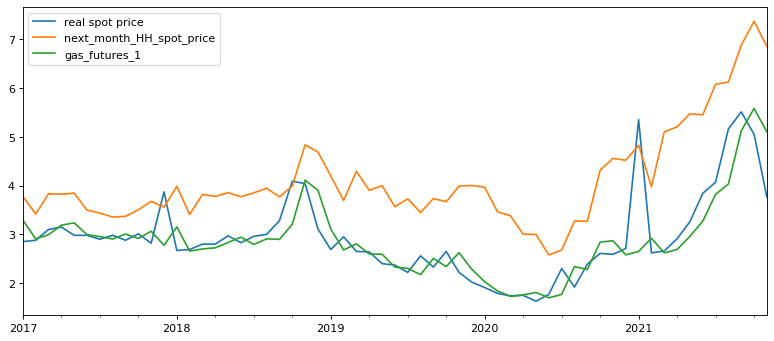

In [700]:
y_ols_pred_train = pd.DataFrame(model_ols.predict(X_train), index=y_train.index, columns=['next_month_HH_spot_price'])
y_ols_pred_test = pd.DataFrame(model_ols.predict(X_test), index=y_test.index, columns=['next_month_HH_spot_price'])
print('RMSE train:', np.sqrt(mean_squared_error(y_train, y_ols_pred_train)))
print('RMSE test:', np.sqrt(mean_squared_error(y_test, y_ols_pred_test)))
fig, ax = plt.subplots(figsize=(12,5))
y_test.plot(ax=ax, label='real spot price')
y_ols_pred_test.plot(ax=ax, label='forecasted spot price')
X_test['gas_futures_1'].to_frame().plot(ax=ax, label='real futures price')
plt.legend()
plt.plot()

#### Polynomial Model

## Model #2: Support Vector Regression

#### Normalization of the data

In [483]:
df1 = df.copy()
X1 = df1.iloc[:, 1:-1].values
y1 = df1.iloc[:, -1].values.reshape(-1,1)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=42)
sc = StandardScaler()
X_train1 = sc.fit_transform(X_train1)
X_test1 = sc.transform(X_test1)

#### Hyper parameter tuning (GridSearch cross-validation)

In [484]:
from sklearn.svm import SVR
reg_sv = SVR()
p_grid = {'C':[1000,10000,100000], 'kernel':['rbf', 'poly']}
search = GridSearchCV(estimator=reg_sv, param_grid=p_grid)
search.fit(X_train1, y_train1.ravel())
sv_preds = search.best_estimator_
y_preds = sv_preds.predict(X_test1)
print('RMSE:', np.sqrt(mean_squared_error(y_test1, y_preds)))

RMSE 1.1400239644115444


## Model #3: Decision Trees

In [703]:
# DecisionTree
from sklearn.tree import DecisionTreeRegressor

model_tree = DecisionTreeRegressor(max_depth=5)
X_train, y_train = train.drop('next_month_HH_spot_price', axis=1), train['next_month_HH_spot_price']
X_test, y_test = test.drop('next_month_HH_spot_price', axis=1), test['next_month_HH_spot_price']
model_tree.fit(X_train, y_train)
dict(zip(features, model_tree.feature_importances_))

{'US_gas_consumption': 0.0,
 'US_gas_supply': 0.0015933532821149504,
 'US_storage_volume': 0.0,
 'US_gas_exports': 0.0,
 'US_gas_imports': 0.011455890918075327,
 'WTI_spot_price': 0.001361251618306913,
 'gas_futures_1': 0.7781956099236534,
 'US_CPI': 0.012487466737013496,
 'dow_jones': 0.0006034710443524032,
 '3m_treasury': 0.02795955908970668,
 '5y_treasury': 0.0032851987611854337,
 'HH_spot_price': 0.16305819862559123,
 'last_month_HH_spot_price': 0.0}

RMSE train: 0.3974818600166334
RMSE test: 0.7532843497866998


[]

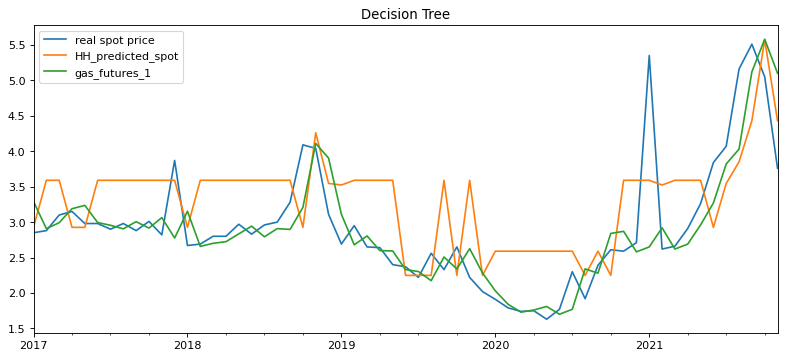

In [704]:
y_tree_pred_train = pd.DataFrame(model_tree.predict(X_train), index=y_train.index, columns=['HH_predicted_spot'])
y_tree_pred_test = pd.DataFrame(model_tree.predict(X_test), index=y_test.index, columns=['HH_predicted_spot'])
print('RMSE train:', np.sqrt(mean_squared_error(y_train, y_tree_pred_train)))
print('RMSE test:', np.sqrt(mean_squared_error(y_test, y_tree_pred_test)))
fig, ax = plt.subplots(figsize=(12,5))
y_test.plot(ax=ax, label='real spot price')
y_tree_pred_test.plot(ax=ax, label='forecasted spot price')
X_test['gas_futures_1'].to_frame().plot(ax=ax, label='real futures price')
plt.title('Decision Tree')
plt.legend()
plt.plot()

In [705]:
# XGBoost
import xgboost as xgb  # conda install xgboost

boosted_tree = xgb.XGBRegressor(n_estimators=2000)
boosted_tree.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
dict(zip(features, model_tree.feature_importances_))

{'US_gas_consumption': 0.0,
 'US_gas_supply': 0.0015933532821149504,
 'US_storage_volume': 0.0,
 'US_gas_exports': 0.0,
 'US_gas_imports': 0.011455890918075327,
 'WTI_spot_price': 0.001361251618306913,
 'gas_futures_1': 0.7781956099236534,
 'US_CPI': 0.012487466737013496,
 'dow_jones': 0.0006034710443524032,
 '3m_treasury': 0.02795955908970668,
 '5y_treasury': 0.0032851987611854337,
 'HH_spot_price': 0.16305819862559123,
 'last_month_HH_spot_price': 0.0}

RMSE: 0.6104196376966822


[]

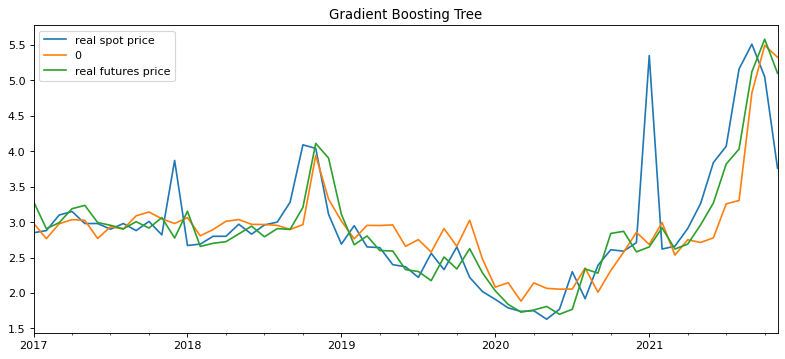

In [706]:
y_xgb_pred = pd.DataFrame(boosted_tree.predict(X_test), index=y_test.index)
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_xgb_pred)))
fig, ax = plt.subplots(figsize=(12,5))
y_test.plot(ax=ax, label='real spot price')
y_xgb_pred.plot(ax=ax, label='forecasted spot price')
X_test['gas_futures_1'].plot(ax=ax, label='real futures price')
plt.title('Gradient Boosting Tree')
plt.legend()
plt.plot()

In [709]:
# XGBoost w/ timeseriessplit (cross-validation)
tss = TimeSeriesSplit(n_splits=5, test_size=24)

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    print('Fold', fold)
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    X_train = train[features]
    y_train = train['next_month_HH_spot_price']

    X_test = test[features]
    y_test = test['next_month_HH_spot_price']

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=200)
    
    fold += 1
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

Fold 0
[0]	validation_0-rmse:4.99628	validation_1-rmse:2.78142
[200]	validation_0-rmse:0.92258	validation_1-rmse:0.51529
[400]	validation_0-rmse:0.39550	validation_1-rmse:0.35155
[401]	validation_0-rmse:0.39482	validation_1-rmse:0.35213
Fold 1
[0]	validation_0-rmse:4.78717	validation_1-rmse:3.14842
[200]	validation_0-rmse:0.88301	validation_1-rmse:0.65280
[400]	validation_0-rmse:0.38669	validation_1-rmse:0.47186
[600]	validation_0-rmse:0.30147	validation_1-rmse:0.45685
[644]	validation_0-rmse:0.28996	validation_1-rmse:0.45757
Fold 2
[0]	validation_0-rmse:4.64057	validation_1-rmse:2.27544
[200]	validation_0-rmse:0.85830	validation_1-rmse:0.43777
[400]	validation_0-rmse:0.39085	validation_1-rmse:0.31381
[415]	validation_0-rmse:0.38063	validation_1-rmse:0.31371
Fold 3
[0]	validation_0-rmse:4.46809	validation_1-rmse:2.39621
[200]	validation_0-rmse:0.82757	validation_1-rmse:0.53401
[400]	validation_0-rmse:0.38527	validation_1-rmse:0.41329
[472]	validation_0-rmse:0.34867	validation_1-rmse:0.

In [710]:
print('RMSE:', np.mean(scores))
print('k-folds RMSE:', scores)

RMSE: 0.4571284933752465
k-folds RMSE: [0.3446565252111953, 0.45682490086069516, 0.31202138586967637, 0.41288998518748843, 0.7592496697471772]


RMSE: 0.7592496697471772


[]

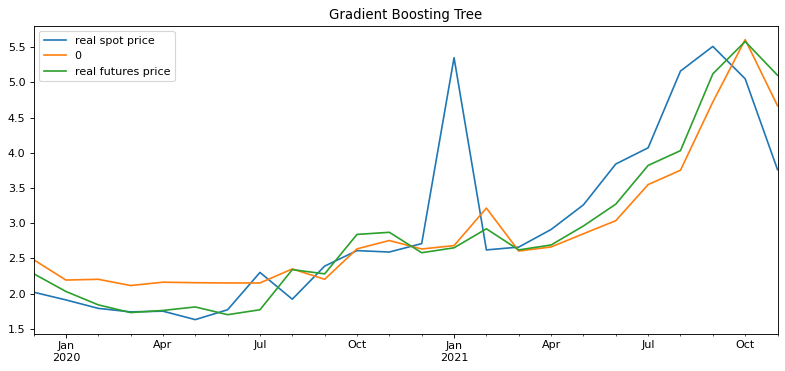

In [711]:
y_kxgb_pred = pd.DataFrame(reg.predict(X_test), index=y_test.index)
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_kxgb_pred)))
fig, ax = plt.subplots(figsize=(12,5))
y_test.plot(ax=ax, label='real spot price')
y_kxgb_pred.plot(ax=ax, label='forecasted spot price')
X_test['gas_futures_1'].plot(ax=ax, label='real futures price')
plt.title('Gradient Boosting Tree')
plt.legend()
plt.plot()

In [648]:
dict(zip(features, reg.feature_importances_))

{'US_gas_consumption': 0.0020116407,
 'US_gas_supply': 0.0018308125,
 'US_storage_volume': 0.0054682745,
 'US_gas_exports': 0.004528886,
 'US_gas_imports': 0.0016872108,
 'WTI_spot_price': 0.0035026118,
 'gas_futures_1': 0.8809996,
 'US_CPI': 0.0018014587,
 'dow_jones': 0.010058801,
 '3m_treasury': 0.0018436576,
 '5y_treasury': 0.0013507361,
 'lag_1m': 0.074790224,
 'lag_2m': 0.007979269,
 'lag_3m': 0.0021467733}

## Model #4: Neural Networks

In [ ]:
#h2o automl
#LSTM

## APPENDIX

#### Unit mapping of the features

In [104]:
features_units_mapping = {
    'HH_spot_price':'USD/MMBtu',
    'US_gas_consumption':'bcf/day',
    'US_gas_supply':'bcf/day',
    'US_storage_volume':'MMcf',
    'US_gas_exports':'MMcf',
    'US_gas_imports':'MMcf',
    'gas_futures_1':'USD/MMBtu',
    'WTI_spot_price':'USD/barrel',
    'TTF_spot_price':'EUR/MWh',
}

#### K-fold cross validation for time series

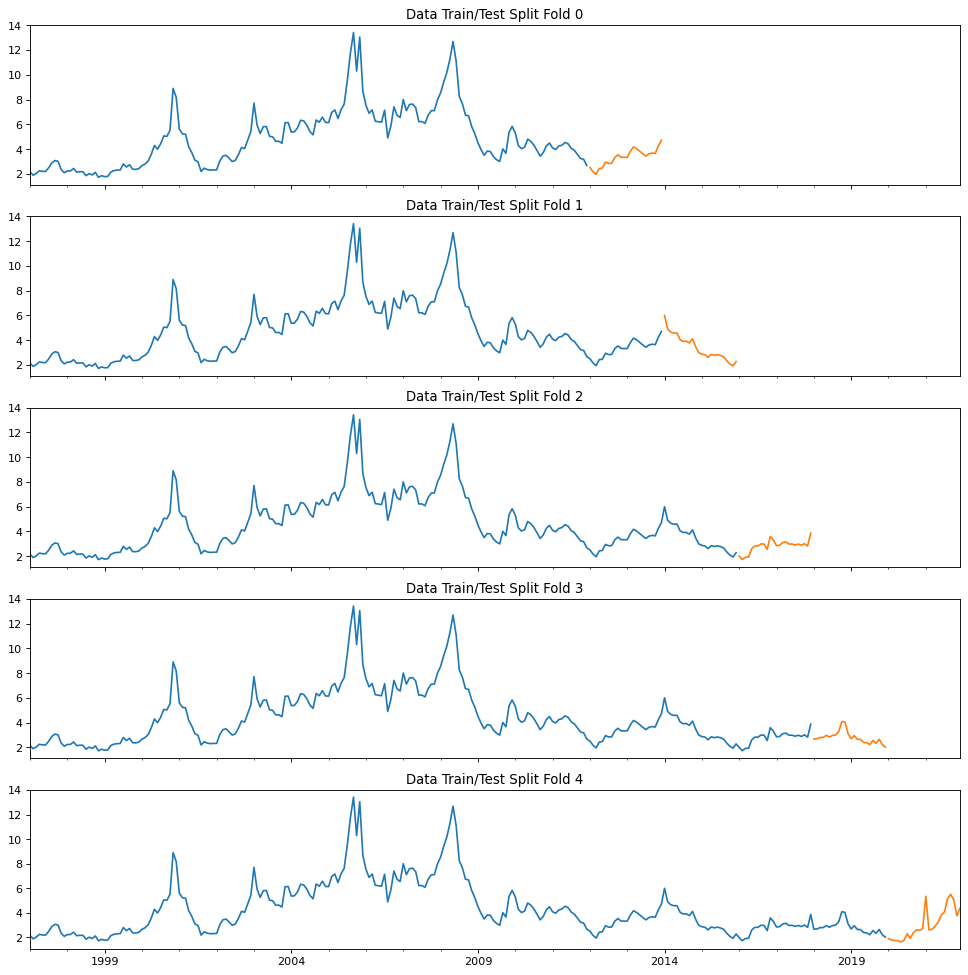

In [507]:
tss = TimeSeriesSplit(n_splits=5, test_size=24)

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['month_ahead_HH_spot'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['month_ahead_HH_spot'].plot(ax=axs[fold],
                         label='Test Set')
    fold += 1
plt.show()


In [330]:
from sklearn.metrics import mean_squared_error, r2_score
#accuracy=r2_score(y_test,y_pred)
#accuracy

#eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True

In [238]:
'''df['HenryHub'] = nasdaqdatalink.get('EIA/NG_RNGWHHD_M', start_date='1997-01-07', end_date='2022-01-31')
df = df.dropna()
x, y = df[features], df['HenryHub']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
print(x_train.shape, x_test.shape)'''

(110, 13) (28, 13)


## STUFF & TESTS

In [ ]:
# energy data (source: EIA)
US_gas_consumption = nasdaqdatalink.get("EIA/STEO_NGTCPUS_M", start_date='1997-01-07', end_date='2022-01-07') # unit: bcf/day
US_storage_volume = nasdaqdatalink.get('EIA/NG_N5020US2_M', start_date='1997-01-07', end_date='2022-01-07') # unit: MMcf
US_gas_exports = nasdaqdatalink.get("EIA/NG_N9130US2_M", start_date='1997-01-07', end_date='2022-01-07') # unit: MMcf
US_gas_imports = nasdaqdatalink.get("EIA/NG_N9100US2_M", start_date='1997-01-07', end_date='2022-01-07') # unit: MMcf
WTI_spot_price = nasdaqdatalink.get("EIA/PET_RWTC_M", start_date='1997-01-07', end_date='2022-01-07') # unit: USD/barrel
TTF_spot_price = yf.get_data('TTF=F', start_date='07/01/1997', end_date='01/07/2022')['adjclose'] # unit: EUR/MWh
# macroeconomic data (source: Federal Reserve)
US_PMI = nasdaqdatalink.get("FRED/NAPM", start_date='1997-01-07', end_date='2022-01-07')
fed_fund_effective_rate_data = nasdaqdatalink.get("FED/RIFSPFF_N_D", start_date='1997-01-07', end_date='2022-01-07')

In [116]:
def get_datasets(source, startdate='1997-01-07', enddate='2022-01-07', auth="Gymx-B5owcdhypB7ydu8"):
    try:
        return nasdaqdatalink.get(source, start_date=startdate, end_date=enddate, authtoken=auth)
    except:
        return yf.get_data(source, start_date=startdate, end_date=enddate, interval='1mo')['adjclose'].to_frame()
    
get_datasets('^DJI')

,adjclose
1997-02-01,6877.740234
1997-03-01,6583.479980
1997-04-01,7009.000000
1997-05-01,7331.000000
1997-06-01,7672.799805
...,...
2021-09-01,33843.921875
2021-10-01,35819.558594
2021-11-01,34483.718750
2021-12-01,36338.300781


In [184]:
nasdaqdatalink.get("FRED/NAPM", start_date='1997-01-07', end_date='2022-01-07')

,VALUE
DATE,
1997-02-01,53.1
1997-03-01,53.8
1997-04-01,53.7
1997-05-01,56.1
1997-06-01,54.9
...,...
2016-01-01,48.2
2016-02-01,49.5
2016-03-01,51.8


In [686]:
df_test = pd.DataFrame()  # contains all features indexed by date
features_test = ['HH_spot_price', 'gas_futures_1']
for feature in features_test:
    data = get_datasets(API_mapping[feature])
    print(data)
    df_test = pd.concat([df_test, data], axis=1, join='outer')
df_test = df.set_axis(features, axis=1, copy=False)  # rename the columns to match the features
df_test

            Value
Date             
1997-01-31   3.45
1997-02-28   2.15
1997-03-31   1.89
1997-04-30   2.03
1997-05-31   2.25
...           ...
2021-08-31   4.07
2021-09-30   5.16
2021-10-31   5.51
2021-11-30   5.05
2021-12-31   3.76

[300 rows x 1 columns]
            Value
Date             
1997-01-31  3.067
1997-02-28  2.065
1997-03-31  1.899
1997-04-30  2.005
1997-05-31  2.253
...           ...
2021-08-31  4.030
2021-09-30  5.120
2021-10-31  5.580
2021-11-30  5.100
2021-12-31  3.860

[300 rows x 1 columns]


ValueError: Length mismatch: Expected axis has 15 elements, new values have 14 elements

In [ ]:
"""X_train, X_test, y_train, y_test = train_test_split(
    df.drop('month_ahead_HH_spot', axis=1), 
    df['month_ahead_HH_spot'], 
    test_size=0.2, 
    random_state=0)"""
